# Getting started

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging

In [3]:
om.__full_version__

'0.4.0.dev0+82fa292'

## Loading and example raw spectra

<IPython.core.display.Javascript object>


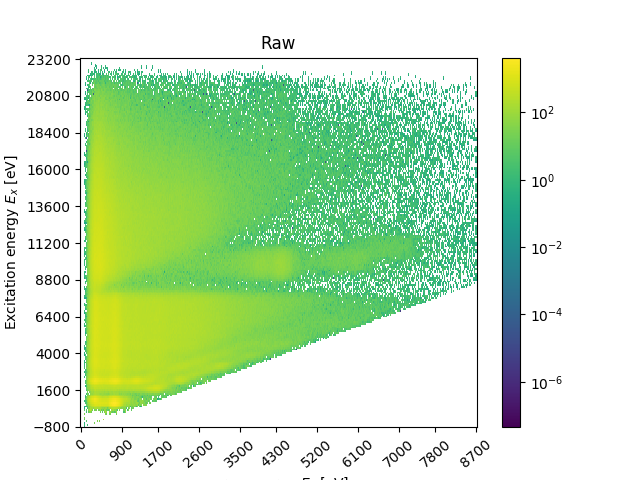

In [4]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.example_raw('Dy164')
# To use you own data, uncomment/adapt the line below instead
# raw = om.Matrix(path="/path/to/matrix.ending")

# Plot the entire matrix
raw.plot();

# Note: We use the semi-colon `;` at the end of the line to silence the output
# in jupyter notebook. This is not necessary, but otherwise you get something like 
# this below printed every time:
#(<matplotlib.collections.QuadMesh at 0x7fafbc422eb8>,
# <matplotlib.axes._subplots.AxesSubplot at 0x7fafc0944a20>,
# <Figure size 640x480 with 2 Axes>)

## Matrix manipulation

The core of the Oslo method involves working with two dimensional spectra. Starting with a raw matrix of $E_x$-$E_\gamma$ coincidences, you typically want to unfold the counts
along the gamma-energy axis and then apply the first-generation method to obtain the matrix of first-generation, or primary, gamma rays from the decaying nucleus.

The two most important utility classes in the package are `Matrix()` and `Vector()`. They are used to store matrices (2D) or vectors (1D) of numbers, typically spectra of counts, along with energy calibration information. 

As these underpin the entire package, they contain many useful functions to make life easier. Loading and saving to several formats, plotting, projections, rebinning and cutting, to mention a few. See the documentation for an exhaustive list.

Their basic structure is:

In [5]:
# mat = ompy.Matrix()
mat = raw
mat.values  # A 2D numpy array
mat.Ex      # Array of mid-bin-edge energy values for axis 0 (i.e. the row axis, or y axis)
mat.Eg      # Array of mid-bin-edge energy values for axis 1 (i.e. the column axis, or x axis)

print("The first gamma-ray energies:\n", mat.Eg[0:10])

The first gamma-ray energies:
 [ -9.682   9.682  29.046  48.41   67.774  87.138 106.502 125.866 145.23
 164.594]


<IPython.core.display.Javascript object>


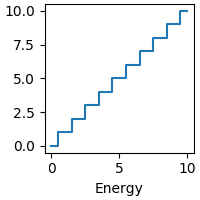

In [6]:
# We can also create a vector, which is useful to store the NLD and gSF.
values = np.arange(11)
E = np.linspace(0, 10, num=11)

fig, ax = plt.subplots(figsize=(2,2), constrained_layout=True)
vec = om.Vector(values=values, E=E)
vec.values  # A 1D numpy array
vec.E       # Array of mid-bin-edge energy values for the single axis
vec.plot(ax=ax);

<IPython.core.display.Javascript object>


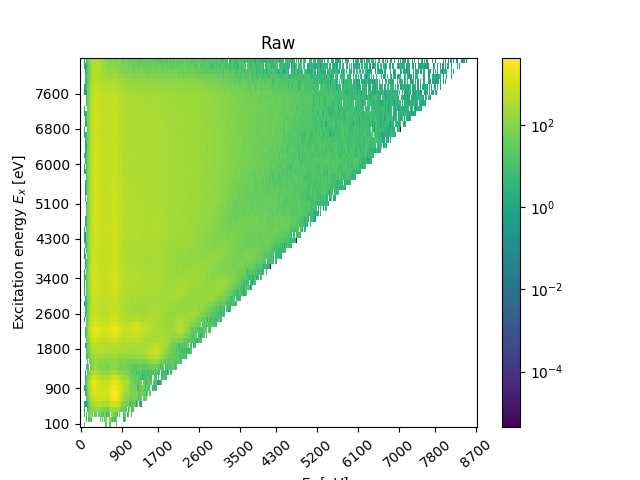

In [7]:
# Cut away counts above the diagonal 
# Remember: Think about what you do here. If you cut them away, they will not
# be used in unfolding etc. This may or may not be what you want.
raw.cut_diagonal(E1=(800, 0), E2=(7500, 7300))
raw.cut('Ex', 0, 8400)
raw.plot();

Note that `Matrix`, `Vector` and several other classes contain mutable objects. If you work on them, you might want to create a *deepcopy*. For `Matrix`, `Vector` this can be archived by the convince method `X.copy`, otherwise use `copy.deepcopy`.

In [8]:
# The "right" way if you don't want to change the original matrix
raw_big_cut = raw.copy()
raw_big_cut.cut('Ex', 0, 4000)
print(raw.Ex.max(), raw_big_cut.Ex.max())

8360.0 3920.0


In [9]:
# The "wrong" way if you don't want to change the original matrix
raw_big_cut2 = raw_big_cut
raw_big_cut2.cut('Ex', 0, 2000)
print(raw_big_cut.Ex.max(), raw_big_cut2.Ex.max())
# oups!: suddenly also `raw_big_cut` was cut, not only raw_big_cut2

2000.0 2000.0


<IPython.core.display.Javascript object>


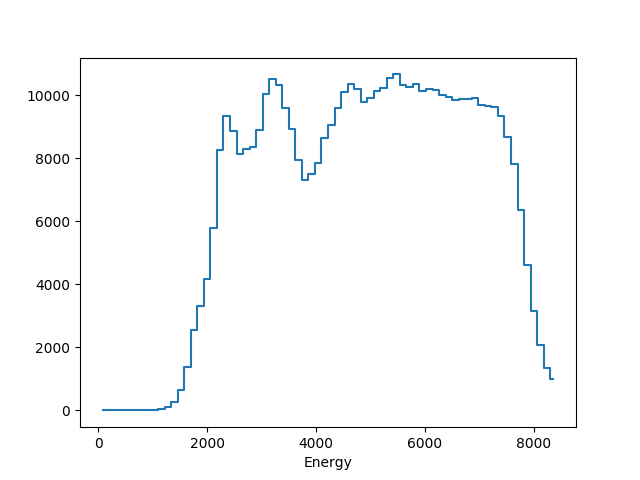

In [10]:
# Plot projections
raw.plot_projection('Ex', Emin=1800, Emax=2600);

Note that you can IPython's has tools to quickly access information on a function, namely the `?` character to explore documentation, the `??` characters to explore source code, and the `Tab key` (or `double-tab`) for auto-completion. Try it out uncommenting the function below.

In [11]:
## Uncomment these lines to query a function
# ?raw.plot_projection

## Unfolding

### Get a response matrix

In [12]:
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "../oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eout_array = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
R_ompy_view, R_tab_view = om.interpolate_response(folderpath, Eout_array, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = om.interpolate_response(folderpath, Eout_array, fwhm_abs=fwhm_abs/10, return_table=True)

Note: The response below 200 keV is interpolation only, as there are no simulations available.
Note: The response below 200 keV is interpolation only, as there are no simulations available.


  warnings.warn("Hello from the fill_negative() function. Please debug me.")



<IPython.core.display.Javascript object>


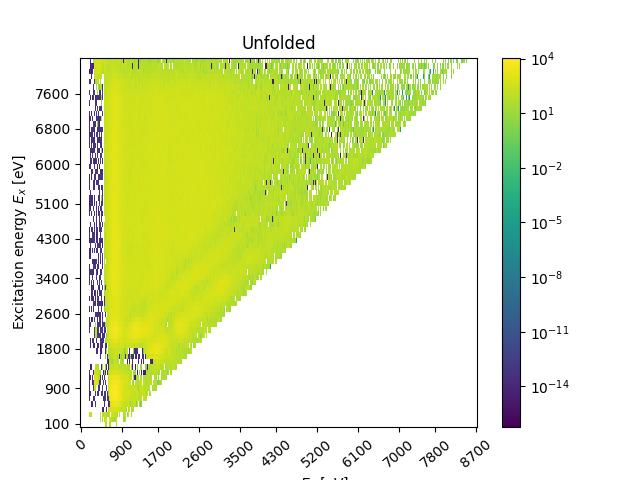

In [13]:
# You can decide to log information and set the logging level (info/debug)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw)
unfolded.plot();

In [14]:
### Generate the first generation matrix

INFO:ompy.firstgeneration:iter 1/10: ε = 7765.63
INFO:ompy.firstgeneration:iter 2/10: ε = 5527.8
INFO:ompy.firstgeneration:iter 3/10: ε = 3093.87
INFO:ompy.firstgeneration:iter 4/10: ε = 2825.23
INFO:ompy.firstgeneration:iter 5/10: ε = 2825.23
INFO:ompy.firstgeneration:iter 6/10: ε = 3093.87
INFO:ompy.firstgeneration:iter 7/10: ε = 2825.23
INFO:ompy.firstgeneration:iter 8/10: ε = 2825.23
INFO:ompy.firstgeneration:iter 9/10: ε = 3093.87
INFO:ompy.firstgeneration:iter 10/10: ε = 2825.23


<IPython.core.display.Javascript object>


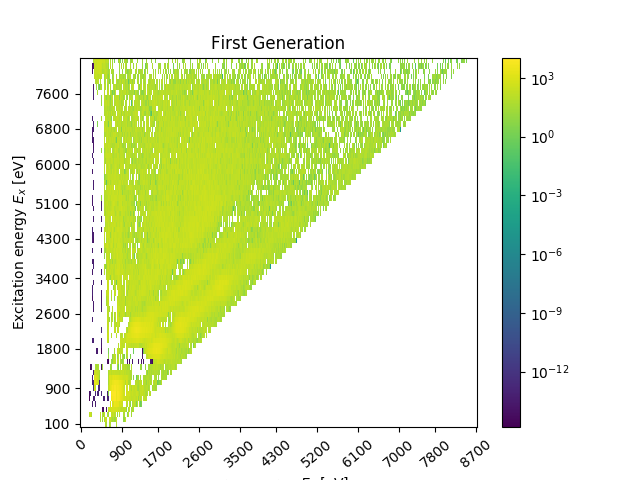

In [15]:
firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

## Propagating statistical uncertainties

In order to propagate the statistical uncertainties from the raw matrix, we use an ensemble based method. We start of my generating en enseble of *raw-like* matrixes. The raw counts are poisson distributed (actually, they are so before background subtraction, see issue on github). If we had counted one another time, we would get slightly different results. 

We take the number of counts $k_i$ in bin $i$ of the raw matrix $R$ as an estimate for the Poisson parameter ("the mean") $λ_i$ . Note that it is an unbiased estimator for $λ_i$, since $E(k) = λ$. To generate a member matrix $R_l$ of the MC ensemble, we replace the counts in each bin $i$ by a random draw from the distribution $\operatorname{Poisson}(k_i)$.

The class Ensemble() provides this feature. Its basic usage is:

In [16]:
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
ensemble.generate(50)    # Generates N perturbated members

  0%|          | 0/50 [00:00<?, ?it/s]INFO:ompy.ensemble:Generating 0
INFO:ompy.ensemble:Generating 1
INFO:ompy.ensemble:Generating 2
INFO:ompy.ensemble:Generating 3
INFO:ompy.ensemble:Generating 4
INFO:ompy.ensemble:Generating 5
INFO:ompy.ensemble:Generating 6
INFO:ompy.ensemble:Generating 7
INFO:ompy.ensemble:Generating 8
INFO:ompy.ensemble:Generating 9
INFO:ompy.ensemble:Generating 10
INFO:ompy.ensemble:Generating 11
INFO:ompy.ensemble:Generating 12
INFO:ompy.ensemble:Generating 13
INFO:ompy.ensemble:Generating 14
INFO:ompy.ensemble:Generating 15
 32%|███▏      | 16/50 [00:00<00:00, 158.23it/s]INFO:ompy.ensemble:Generating 16
INFO:ompy.ensemble:Generating 17
INFO:ompy.ensemble:Generating 18
INFO:ompy.ensemble:Generating 19
INFO:ompy.ensemble:Generating 20
INFO:ompy.ensemble:Generating 21
INFO:ompy.ensemble:Generating 22
INFO:ompy.ensemble:Generating 23
INFO:ompy.ensemble:Generating 24
INFO:ompy.ensemble:Generating 25
INFO:ompy.ensemble:Generating 26
INFO:ompy.ensemble:Generating 27


The generated members are saved to disk and can be retrieved. Unfolded members can be retrieved as `ensemble.get_unfolded(i)`, for example. Their standard deviation is `ensemble.std_unfolded` for the unfolded matrixes, etc.

We can now plot the standard deviation of all ensemble members for the raw, unfolded and first generation spectrum 

<IPython.core.display.Javascript object>


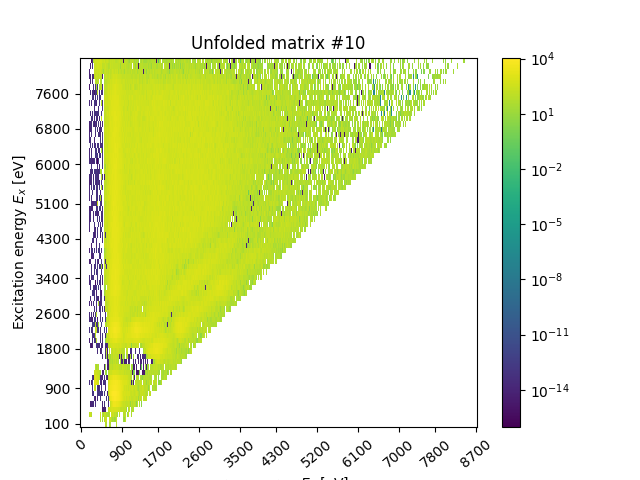

<IPython.core.display.Javascript object>


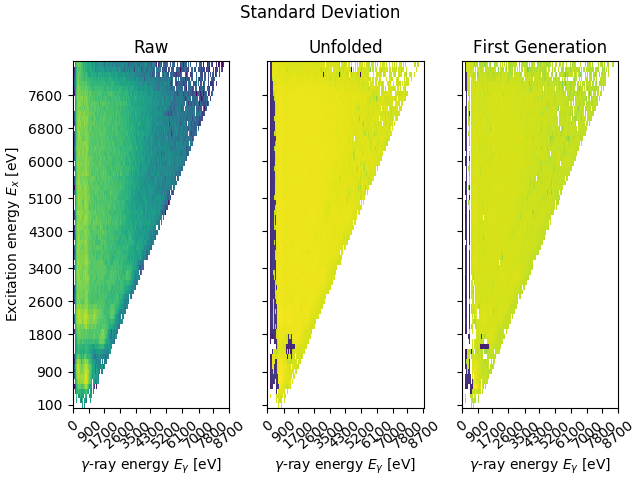

In [17]:
i_unfolded = 10
matrix = ensemble.get_unfolded(i_unfolded)
matrix.plot(title=f"Unfolded matrix #{i_unfolded}")

# Following commands plots all std. deviations
ensemble.plot();

## Nuclear level density and gamma strength function

After matrix has been cut, unfolded and firstgen'd, perhaps ensembled, its nuclear level density (nld) and gamma strength function ($\gamma$SF) can be extracted using the `Extractor()` class. For a single matrix, its usage is

In [18]:
# cutout = primary.trapezoid(Ex_min=4000, Ex_max=8000, Eg_min=1000, inplace=False)
# cutout_std = ensemble.std_firstgen.trapezoid(Ex_min=4000, Ex_max=8000, Eg_min=1000, inplace=False)
# extractor = om.Extractor()
# nld, gsf = extractor.decompose(cutout, std=cutout_std)

When extracting nld and gsf from an ensemble, a trapezoidal cutout must be performed on each ensemble member. This is achieved by `Action()` which allows for delayed function calls on matrices and vectors. This way we don't cut the raw matrix at `Ex_min`, but this will only happen before the extraction.

100%|██████████| 50/50 [00:00<00:00, 736.68it/s]


<IPython.core.display.Javascript object>


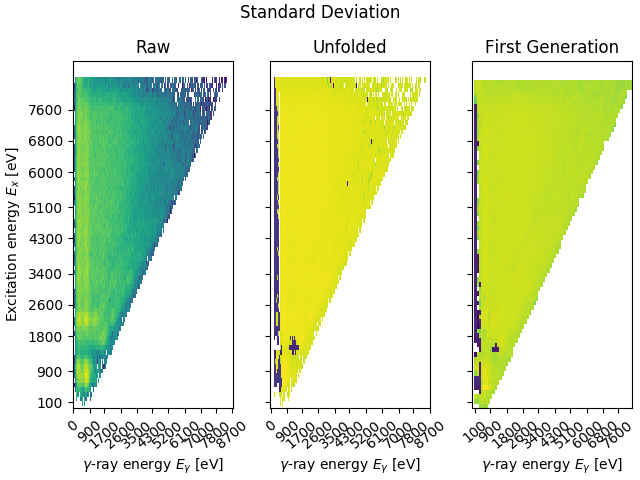

In [19]:
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=4000, Ex_max=7000, Eg_min=1000, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut
# Running the lines below directy, would most probably 
# result in a error like
# The AssertionError: Ex and Eg must have the same step size
#
# Why? The extraction assumes that Ex and Eg have the same binning. Thus we
# need to rebin the ensemble. This works will work inplace. 
# Note: As always, be careful will mid-bin vs lower bin calibration.
E_rebinned = ensemble.get_firstgen(0).Ex
ensemble.rebin(E_rebinned, member="firstgen")
ensemble.plot();

In [20]:
# now we can extract the NLD and gSF for N of the samples of the ensemble 
# (here just 10 to speed things up)
extractor.size = 10
extractor.extract_from(ensemble, regenerate=True)

 10%|█         | 1/10 [00:00<00:04,  2.07it/s]

Optimization terminated successfully.
         Current function value: 2528.729265
         Iterations: 4
         Function evaluations: 4431


 20%|██        | 2/10 [00:01<00:03,  2.01it/s]

Optimization terminated successfully.
         Current function value: 2471.534835
         Iterations: 4
         Function evaluations: 4422


 30%|███       | 3/10 [00:01<00:03,  1.93it/s]

Optimization terminated successfully.
         Current function value: 2648.752900
         Iterations: 4
         Function evaluations: 4443


 40%|████      | 4/10 [00:02<00:03,  1.91it/s]

Optimization terminated successfully.
         Current function value: 2492.389747
         Iterations: 4
         Function evaluations: 4441


 50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Optimization terminated successfully.
         Current function value: 2491.841576
         Iterations: 4
         Function evaluations: 4429


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

Optimization terminated successfully.
         Current function value: 2501.165444
         Iterations: 4
         Function evaluations: 4427


 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

Optimization terminated successfully.
         Current function value: 2349.167808
         Iterations: 4
         Function evaluations: 4419


 80%|████████  | 8/10 [00:04<00:01,  1.83it/s]

Optimization terminated successfully.
         Current function value: 2604.851863
         Iterations: 4
         Function evaluations: 4432


 90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

Optimization terminated successfully.
         Current function value: 2672.799762
         Iterations: 4
         Function evaluations: 4430


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

Optimization terminated successfully.
         Current function value: 2620.334824
         Iterations: 4
         Function evaluations: 4434


The resulting `nld` and `gsf` are saved to disk and exposed as `extractor.nld` and `extractor.gsf`

### Plotting the results before normalization

<IPython.core.display.Javascript object>


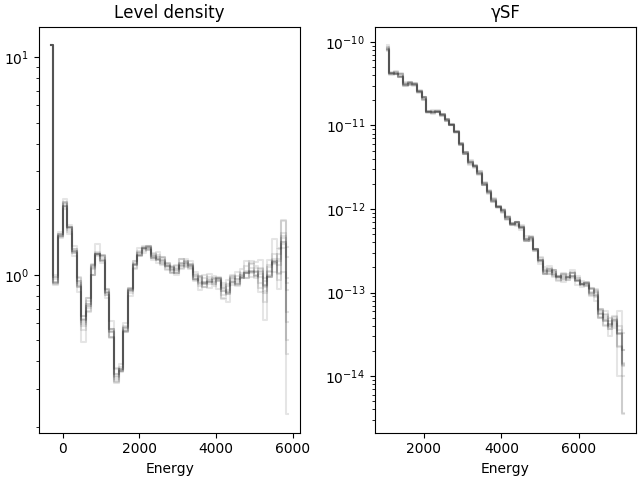

Text(0.5, 1.0, 'γSF')

In [21]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
for nld, gsf in zip(extractor.nld, extractor.gsf):
    nld.plot(ax=ax[0], scale="log", color='k', alpha=1/10)
    gsf.plot(ax=ax[1], scale="log", color='k', alpha=1/10)
ax[0].set_title("Level density")
ax[1].set_title("γSF")

Or maybe you are more used to displaying the results with std. deviations?

**Note**: This may be erroneous, as the nld and gsf are not normalized yet!  
Thus, in principal, we might evaluate std. devs. of the *same solution* with different  
transformations. Before we normalize, we don't know. And they have the same $\chi^2$.  
That was the reason for the *trouble* with normalization.



<IPython.core.display.Javascript object>


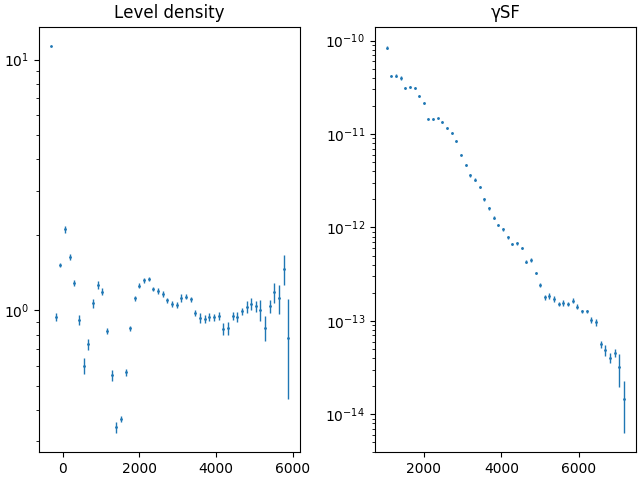

(<Figure size 640x480 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f788f562550>,
       dtype=object))

In [22]:
extractor.plot()

## Normalization

Does it still look *strange*? probably because you are only used to see the normalized results.

The proper normalization is will come as a feature very(!) soon. For now, let's just see how the transformed results would look like.

<IPython.core.display.Javascript object>


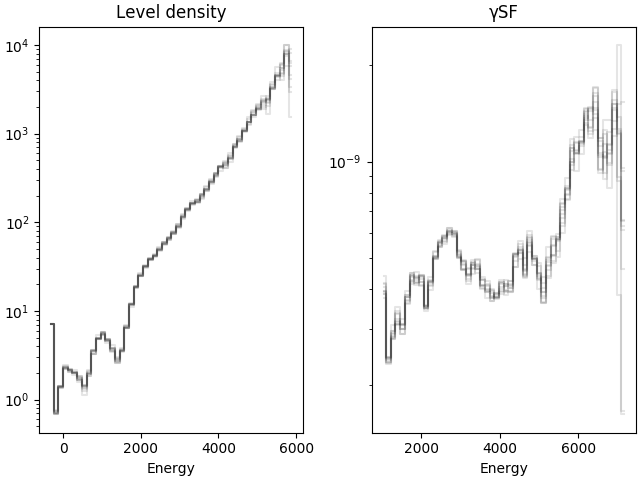

In [23]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_transformed(alpha):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=1, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=1, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].set_title("Level density")
    ax[1].set_title("γSF")

plot_transformed(alpha=0.0015)